# Project Template 
 
This template use principal component analysis and Bayesian classifier for classifier design and evaluation. 

In [1]:
# revision for output files
rev = "r10"

In [2]:
# Output results directory
rDir = "results"

# Output plots direcotry
pDir = "plots"

## Part 1    
The handwritten digit data from 
https://github.com/davidflanagan/notMNIST-to-MNIST (four files) was imported and stored in the **`data`** subdirectory. You need both the training and testing data for this template. The Python code suggested in [Read_MNIST.html](https://ucsc-extension.instructure.com/courses/784/files/95974/download?wrap=1) was modified to read and parse the data in this data set by changing the input file names.

* A copy of the training and test data are stored in the **`data`** subdirectory.
* The output plots are stored in the **`plots`** subdirectory.
* Some classification results are stored as CSV files in the **`results`** subdirectory.

In [3]:
import os, struct
import matplotlib as plt
from array import array as pyarray
import numpy as np
import time
from pylab import *
import pandas as pd
from scipy.stats import multivariate_normal
import sys
from collections import Counter

In [4]:
def load_mnist(dataset="training", digits=range(10), path='./data'):
    
    """
    Adapted from: http://cvxopt.org/applications/svm/index.html?highlight=mnist
    """

    if dataset == "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = np.zeros((N, rows, cols), dtype=uint8)
    labels = np.zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]

    return images, labels

## Part 2
Prepare the data that will use for this project.

In [5]:
# Convert between digit and letter
digit2letter = pd.Series(list("ABCDEFGHIJ"))
letter2digit = {digit2letter[d] : d for d in range(10)}

In [6]:
print digit2letter
print letter2digit

0    A
1    B
2    C
3    D
4    E
5    F
6    G
7    H
8    I
9    J
dtype: object
{'A': 0, 'C': 2, 'B': 1, 'E': 4, 'D': 3, 'G': 6, 'F': 5, 'I': 8, 'H': 7, 'J': 9}


In [7]:
# use all letters
digits = np.array(range(10))

In [8]:
letters = digit2letter[digits].values

In [9]:
print digits
print type(digits)
print letters
print type(letters)

[0 1 2 3 4 5 6 7 8 9]
<type 'numpy.ndarray'>
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']
<type 'numpy.ndarray'>


Load training and test data set.

In [10]:
images, labels = load_mnist('training', digits=digits)
images_test, labels_test = load_mnist('testing', digits=digits)

## Part 3   
Prepare the X matrix and target vector T

In [11]:
#def select_random_samples(X, T, num_samples = 16, rseed=0):
#    if rseed != None :
#        np.random.seed(rseed)
#    idx = np.random.choice(T.shape[0],size=num_samples)
#    XList = X[idx]
#    TList = T[idx]
#    return XList, TList
#
#def plot_samples(XList, TList, width=28, ncol=4, fName= None):
#    fig = plt.figure()
#    num_samples = XList.shape[0]
#    for n, x  in enumerate(XList) :
#        sample = x.reshape(width, width)
#        plt.subplot((num_samples+ncol-1)/ncol, ncol, n+1)
#        plt.imshow(sample, interpolation='None', cmap='gray')
#        plt.title("{}".format(TList[n]))
#        plt.xticks([])
#        plt.yticks([])
#    plt.tight_layout(pad=1, w_pad=0.2, h_pad=0.2)
#    fig.set_size_inches(6,6)
#    if fName != None:
#        savefig(fName, bbox_inches='tight')
#    plt.show()
#
#def plot_random_samples(X, T, width=28, num_samples = 16, ncol=4, rseed=0, fName=None):
#    XList, TList = select_random_samples(X,T,16, rseed)
#    plot_samples(XList, TList, width, ncol, fName)
#
#def plot_sample(x,title="",width=28,fName=None) :
#    fig = plt.figure()
#    sample = x.reshape(width, width)
#    # interploation can be 'nearest' to put grid at the center the pixels
#    plt.imshow(sample, interpolation='None', cmap='gray')
#    plt.title(title)
#    plt.xticks([])
#    plt.yticks([])
#    if fName != None:
#        savefig(fName, bbox_inches='tight')
#    plt.show()    

In [12]:
# converting from NX28X28 array into NX784 array
def reformatSamples(images,labels) :
    flatimages = list()
    for i in images:
        flatimages.append(i.ravel())
    X = np.asarray(flatimages)
    T = labels.reshape(-1)
    return X, T

def convertDigitsToLetters(T,digit2letter) :
    L = np.array([digit2letter[d] for d in T])
    return L

In [13]:
X, T = reformatSamples(images,labels)
L = convertDigitsToLetters(T,digit2letter)

X_test, T_test =  reformatSamples(images_test,labels_test)
L_test = convertDigitsToLetters(T_test,digit2letter)

In [14]:
print "Shape of matrix     : ", X.shape
print "Shape of labels     : ", T.shape
print "Unique Lables       : ", tuple(set(T))
print "Mins and Max Values : ", (np.amin(X),np.amax(X))

Shape of matrix     :  (60000, 784)
Shape of labels     :  (60000,)
Unique Lables       :  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
Mins and Max Values :  (0, 255)


In [15]:
print "Shape of test matrix     : ", X_test.shape
print "Shape of test labels     : ", T_test.shape
print "Unique test Lables       : ", tuple(set(T_test))
print "Mins and Max test Values : ", (np.amin(X_test),np.amax(X_test))

Shape of test matrix     :  (10000, 784)
Shape of test labels     :  (10000,)
Unique test Lables       :  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
Mins and Max test Values :  (0, 255)


## Check training vector by plotting image 

In [16]:
#fName = os.path.join(pDir,"samples_of_X_{}.png".format(rev))
#XList, TList = select_random_samples(X,L,16)
#plot_samples(XList, TList, fName = fName)

## Part 4   
Go through the XZCVP procedure to produce P which is the 2D approximation to X. Produce a 2D scatterplot showing the two classes. Plot the mean vector `mu` and 16 eigenvectors calculated in completing this step.

In [17]:
def getPCA(X) :
    C = np.cov(X,rowvar=False)
    w, U = np.linalg.eigh(C)
    
    # reorder the eigenvector and eigenvector in decreasing order of eigenvalue
    V = U[:,::-1] # eigenvector
    s = w[::-1]   # eigenvalue
    return C, V, s

In [18]:
C, V, s = getPCA(X)
mu = np.mean(X,axis=0)
Z = X - mu

Check results.

In [19]:
print "shape of mu :", mu.shape
print "max of mu   :", mu.max()
print "min of mu   :", mu.min()

shape of mu : (784,)
max of mu   : 172.874566667
min of mu   : 38.62675


In [20]:
print "shape of Z  :", Z.shape
print "max of Z    :", Z.max()
print "min of Z    :", Z.min()
print "max of mean(Z) :", Z.mean(axis=0).max()
print "min of mean(Z) :", Z.mean(axis=0).min()

shape of Z  : (60000, 784)
max of Z    : 216.37325
min of Z    : -172.874566667
max of mean(Z) : 7.99196205511e-13
min of mean(Z) : -8.80027073435e-13


In [21]:
#fName = os.path.join(pDir,"mean_of_X_{}.png".format(rev))
#plot_sample(mu,"means of all letters ",fName=fName)

In [22]:
#fig = plt.figure()
#plt.plot(range(len(mu)),mu)
#plt.ylim([0,180])
#plt.xlim([0,800])
#fig.set_size_inches(8,8)
#fName = os.path.join(pDir,'mean_{}.png'.format(rev))
#savefig(fName, bbox_inches='tight')
#plt.show()

In [23]:
#fName = os.path.join(pDir,"samples_of_Z_{}.png".format(rev))
#savefig(fName, bbox_inches='tight')
#plot_random_samples(Z,L,fName=fName)

In [24]:
#fig = plt.figure()
#plt.imshow(C, interpolation='None', cmap=cm.gray)
#plt.axis("off")
#plt.title("Covariance Matrix")
#fig.set_size_inches(8,8)
#fName = os.path.join(pDir,'cov_{}.png'.format(rev))
#savefig(fName, bbox_inches='tight')
#plt.show()

In [25]:
#fig = plt.figure()
#plt.plot(range(len(s)),s)
#plt.title("Eigen Value")
#plt.grid("on")
#fig.set_size_inches(8,8)
#fName = os.path.join(pDir,'eigen_value_{}.png'.format(rev))
#savefig(fName, bbox_inches='tight')
#plt.show()

In [26]:
#fig = plt.figure()
#plt.plot(range(len(s)),s.cumsum()/s.sum())
#plt.title("Normalized Cumulative Sum of Eigen Value")
#plt.ylim([0,1.2])
#plt.grid("on")
#fig.set_size_inches(8,8)
#fName = os.path.join(pDir,'eigen_value_cum_sum_{}.png'.format(rev))
#savefig(fName, bbox_inches='tight')
#plt.show()

In [27]:
print "L2 norm of (V*V.T - I) :", np.linalg.norm(np.dot(V,V.T) - np.identity(V.shape[0]))
print "Max of (V.T*V - I)     :", np.max(np.dot(V.T,V) - np.identity(V.shape[0]))
print "Min of (V.T*V - I)     :", np.min(np.dot(V.T,V) - np.identity(V.shape[0]))
print "L2 norm of (V*V.T - I) :", np.linalg.norm(np.dot(V,V.T) - np.identity(V.shape[0]))
print "Max of (V.T*V - I)     :", np.max(np.dot(V.T,V) - np.identity(V.shape[0]))
print "Min of (V.T*V - I)     :", np.min(np.dot(V.T,V) - np.identity(V.shape[0]))

L2 norm of (V*V.T - I) : 7.26119624262e-14
Max of (V.T*V - I)     : 2.88657986403e-15
Min of (V.T*V - I)     : -2.64361015717e-15
L2 norm of (V*V.T - I) : 7.26119624262e-14
Max of (V.T*V - I)     : 2.88657986403e-15
Min of (V.T*V - I)     : -2.64361015717e-15


In [28]:
C2 = np.dot(V,np.dot(np.diag(s),V.T))
print "L2 norm of (V*S*V.T - C) :", np.linalg.norm(C-C2)
print "Max of (V*S*V.T - C)     :", np.max(C-C2)
print "Min of (V*S*V.T - C)     :", np.min(C-C2)

L2 norm of (V*S*V.T - C) : 7.78360498998e-09
Max of (V*S*V.T - C)     : 1.40062184073e-10
Min of (V*S*V.T - C)     : -1.6916601453e-10


Plot the first 16 principle components.

In [29]:
#m= 16
#tittles = ["PC {}".format(x+1) for x in range(m)]
#fName = os.path.join(pDir,'samples_of_pc_{}.png'.format(rev))
#plot_samples(V.T[:m], tittles, width=28, ncol=4, fName=fName)

Use `n` principle components for classification.

In [30]:
n = 50

P = np.dot(Z,V[:,:n])
R = np.dot(P,V[:,:n].T)
RX = R + mu

In [31]:
#fig = plt.figure()
#plt.plot(range(n),P.max(axis=0),label="max")
#plt.plot(range(n),P.min(axis=0),label="min")
#plt.plot(range(n),P.mean(axis=0),label="mean")
#plt.plot(range(n),P.std(axis=0),label="std")
#plt.ylabel("Value of Principle Component")
#plt.xlabel("Index of Principle Component")
#plt.legend()
#fig.set_size_inches(8,8)
#fName = os.path.join(pDir,'describe_PC_n{}_{}.png'.format(n,rev))
#savefig(fName, bbox_inches='tight')
#plt.show()

In [32]:
print P.max()
print P.min()
print P.shape

2970.94607214
-3852.0903665
(60000, 50)


Display scatter plot of a list of letters.

In [33]:
a = list("ABCD")
print a
print "".join(a)

['A', 'B', 'C', 'D']
ABCD


In [34]:
#def scatter_plot(P,L,pcIdx1,pcIdx2,letterList,rev) :
#    fig = plt.figure()
#    # following the convention in lecture note ScatterPlot.html
#    colors = ["r","lime","b","y","c","m","k","tan","pink","darkred"]
#    for i, letter in enumerate(letterList) :
#        plt.scatter(P[L==letter,pcIdx2],P[L==letter,pcIdx1],s=0.1,c=colors[i],label=letter)
#    plt.axes().set_aspect('equal')
#    #plt.axes().set_aspect('equal', 'datalim')
#    plt.xlabel("Principle Component {}".format(pcIdx2))
#    plt.ylabel("Principle Component {}".format(pcIdx1))
#    plt.axhline(0, color='grey')
#    plt.axvline(0, color='grey')
#    plt.ylim([-5000,5000])
#    plt.xlim([-5000,5000])
#    plt.legend()
#    plt.gca().invert_yaxis()
#    fig.set_size_inches(8,8)
#    fName = os.path.join(pDir,'scatter_PC{}_PC{}_{}_{}.png'.format(pcIdx1,pcIdx2,"".join(letterList),rev))
#    savefig(fName, bbox_inches='tight')    
#    plt.show()
#
#

In [35]:
#scatter_plot(P,L,0,1,["A","B","C", "D"],rev)

In [36]:
#scatter_plot(P,L,2,3,["A","B","C","D"],rev)

In [37]:
#scatter_plot(P,L,4,5,["A","B","C","D"],rev)

In [38]:
#scatter_plot(P,L,6,7,["A","B","C","D"],rev)

In [39]:
#scatter_plot(P,L,8,9,["A","B","C","D"],rev)

In [40]:
#scatter_plot(P,L,n-2,n-1,["A","B","C","D"],rev)

## Part 5    
Visually verify that the corresponding element of P, when projected back to 784 dimensions and visualized as an image still looks like the original image. That is, visually verify that reduction in dimension does not significantly compromise the identity of the samples. 

In [41]:
#fName = os.path.join(pDir,"samples_of_RX_n{}_{}.png".format(n,rev))
#plot_random_samples(RX,L,fName=fName)

In [42]:
#plot_random_samples(X,L)

## Part 6    
Build a Bayesian classifier assuming that the feature vectors are distributed normally in the reduced dimensional space.  In order to use the  classifier on a 784D query, the mean vectors and eigenvectors (Step 4 above) are needed.

## 6.1 Bayesian
Build a $n$-D Bayesian classifier assuming that the feature vectors are distributed normally in the reduced dimensional space. 
 

#### Number of samples in each letter

In [43]:
N = P.shape[0]
NList = np.array([P[T==x].shape[0] for x in digits])

In [44]:
print "NList =", NList
print "N     =", N

NList = [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
N     = 60000


#### Mean of the principle components of each letter 

In [45]:
muList = np.array([P[T==x].mean(axis=0) for x in digits])

In [46]:
print muList.shape

(10, 50)


In [47]:
#fig = plt.figure()
#plt.plot(muList.T)
#plt.title("Mean of Principle Component")
#plt.xlabel("Index of Principle Component")
#plt.axhline(0, color='grey')
#plt.legend(letters,loc='upper right')
#fig.set_size_inches(8,8)
#fName = os.path.join(pDir,'mean_of_pc_n{}_{}.png'.format(n,rev))
#savefig(fName, bbox_inches='tight')
#plt.show()

#### Covariance matrix of the principle component of each letter

In [48]:
covList = np.array([np.cov(P[T==x],rowvar=False) for x in digits])

In [49]:
print covList.shape

(10, 50, 50)


## Part 7   
Run P through the classifiers and record the results (e.g. what is X recognized as? With what probability? 

### Functions for classification

#### A function to get the classification `xc` and probability `xc_p` of a sample `p`

In [50]:
def bays_classifier(p,NList,muList,covList,classList) :
    xH = np.array([NList[x]*multivariate_normal.pdf(p, mean=muList[x], cov=covList[x]) for x in range(NList.shape[0])])
    xc = np.argmax(xH)
    xc_p = xH[xc]/xH.sum()
    xc = classList[xc]
    return xc, xc_p

#### A function to get the classifications `cb` as digits and the probability `cbp` of all samples in `P`

In [51]:
def bayes_classify(P,NList,muList,covList,digits) :
    cb = []  # classfied as indexes
    cbp = [] # probability
    for i, p in enumerate(P) :
        x_cb, x_cb_p = bays_classifier(p,NList,muList,covList,digits)
        cb.append(x_cb)
        cbp.append(x_cb_p)
        #if (i%1000 == 0) : sys.stdout.write('.'),
    #print
    cb = np.array(cb)
    cbp = np.array(cbp)
    return cb, cbp

In [52]:
# print bays_classifier(P[0],NList,muList,covList,digits)
print T[0], L[0]

5 F


### Functions for confusion matrix and related information

In [53]:
def getCount(groundTruth,gClass,predicted,pClass) :
    return np.sum(np.logical_and(groundTruth == gClass, predicted == pClass))
  
def getTP(groundTruth,predicted,pClass) :
    return np.sum(np.logical_and(groundTruth == pClass, predicted == pClass))

def getTN(groundTruth,predicted,pClass) :
    return np.sum(np.logical_and(groundTruth != pClass, predicted != pClass))
   
def getFP(groundTruth,predicted,pClass) :
    return np.sum(np.logical_and(groundTruth != pClass, predicted == pClass))

def getFN(groundTruth,predicted,pClass) :
    return np.sum(np.logical_and(groundTruth == pClass, predicted != pClass))

def get_acc(groundTruth,predicted) :
    return np.sum(groundTruth == predicted)/float(predicted.shape[0])

def get_CM2(groundTruth,predicted,pClass) :
    TP = getTP(groundTruth,predicted,pClass)
    TN = getTN(groundTruth,predicted,pClass)
    FP = getFP(groundTruth,predicted,pClass)
    FN = getFN(groundTruth,predicted,pClass)
    return np.array([[TP, FN], [FP, TN]])

def get_sensitivity(TP, FN, FP, TN) :
    return TP / float(TP + FN)
    
def get_specificity(TP, FN, FP, TN) :
    return TN / float(FP+TN)
    
def get_ppv(TP, FN, FP, TN) :
    return TP / float(TP+FP)    
    
def get_accuracy(TP, FN, FP, TN) :
    return (TP + TN) / float(TP + FN + FP + TN)   

def get_CM(groundTruth,predicted,classList) :
    CM = np.zeros((len(classList),len(classList)))
    for i, t in enumerate(classList) :
        for j, p in enumerate(classList) : 
          CM[i,j] =  np.sum(np.logical_and(groundTruth == t, predicted == p))  
    CM = pd.DataFrame(CM)
    CM.columns = classList
    CM.index = classList
    return CM

metrics_func = {
    'Sensitivity' : get_sensitivity,
    'Specificity' : get_specificity,
    'PPV' : get_ppv,
    'Accuracy' : get_accuracy
}

#### Classify the training and test set with `n` principle components
It is not very fast. Please wait.
 
The eigenvectors `V` and the mean vector `mu` were previously computed by
```
C, V, s = getPCA(X)
mu = np.mean(X,axis=0)
```

In [54]:
def augment_with_kernel(X) :
    Xa = np.insert(X,0,1,axis=1)
    iu = np.triu_indices(Xa.shape[1])
    Xk = []
    for x in Xa:
        xT_x = x.reshape(-1,1)*x
        Xk.append(xT_x[iu])
    return np.array(Xk)

In [55]:
XX = arange(12).reshape(4,3)
print XX
print

Xa = np.insert(XX,0,1,axis=1)
print Xa
print

Xk = augment_with_kernel(XX)
for i, x in enumerate(Xa):
    print x.reshape(-1,1)*x
    print Xk[i]
    print

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]

[[ 1  0  1  2]
 [ 1  3  4  5]
 [ 1  6  7  8]
 [ 1  9 10 11]]

[[1 0 1 2]
 [0 0 0 0]
 [1 0 1 2]
 [2 0 2 4]]
[1 0 1 2 0 0 0 1 2 4]

[[ 1  3  4  5]
 [ 3  9 12 15]
 [ 4 12 16 20]
 [ 5 15 20 25]]
[ 1  3  4  5  9 12 15 16 20 25]

[[ 1  6  7  8]
 [ 6 36 42 48]
 [ 7 42 49 56]
 [ 8 48 56 64]]
[ 1  6  7  8 36 42 48 49 56 64]

[[  1   9  10  11]
 [  9  81  90  99]
 [ 10  90 100 110]
 [ 11  99 110 121]]
[  1   9  10  11  81  90  99 100 110 121]



In [56]:
def train_and_test_bayes(X_train,T_train,X_test,T_test,digits,V,mu,n):
    
     
    #print "Training Classifier with {} PC".format(n)
    Z = X_train - mu
    P = np.dot(Z,V[:,:n])
    muList = np.array([P[T_train==x].mean(axis=0) for x in digits])
    covList = np.array([np.cov(P[T_train==x],rowvar=False) for x in digits])
    #print "muList", muList
    #print "covList", covList
    NList = np.array([P[T_train==x].shape[0] for x in digits])
    #print "NNList", covList
    
    cb, cbp = bayes_classify(P,NList,muList,covList,digits)
     
    #print "Testing  Classifier with {} PC".format(n)
    Z_test = X_test - mu
    P_test = np.dot(Z_test,V[:,:n])
    cb_test, cbp_test = bayes_classify(P_test,NList,muList,covList,digits)
    
    return cb, cb_test

def map_kesler(T,digits) :
    Tk = (T.reshape(-1,1) == digits).astype(int) * 2 -1
    return np.array(Tk)
    
def augment(X) :
    Xa = np.insert(X,0,1,axis=1)
    return Xa
    
def train_linear_classifier(Xa,T) :
    Xa_pinv = np.linalg.pinv(Xa)
    Wt = np.dot(Xa_pinv,T)
    return Wt

def linear_classify(Xa,Wt,digits) :
    T_pred =  np.dot(Xa,Wt)
    Xc =  np.argmax(T_pred, axis=1)
    return(digits[Xc])
    
def train_and_test_linear(X_train,T_train,X_test,T_test,digits,V,mu,n,useKernel=False):
    #print "Training Classifier with {} PC".format(n)h
    Z = X_train - mu
    P = np.dot(Z,V[:,:n])

    Tk = map_kesler(T_train,digits)
    
    if useKernel :
        Xa = augment_with_kernel(P)
    else :
        Xa = augment(P)
        
    Wt = train_linear_classifier(Xa,Tk)
    T_pred = linear_classify(Xa,Wt,digits)
     
    #print "Testing  Classifier with {} PC".format(n)
    Z_test = X_test - mu
    P_test = np.dot(Z_test,V[:,:n])

    if useKernel :
        Xa_test = augment_with_kernel(P_test)
    else :
        Xa_test = augment(P_test)
        
    T_pred_test = linear_classify(Xa_test,Wt,digits)
    
    return T_pred, T_pred_test
    
def train_and_test_onevsall(X_train,T_train,X_test,T_test,digits,n, model=0):
    if (model == 2):
        cb_onevsall, cb_test_onevsall = train_and_test_bayes(X_train,T_train,X_test,T_test,digits,V,mu,n)
    if (model == 0):
        cb_onevsall, cb_test_onevsall = train_and_test_linear(X_train,T_train,X_test,T_test,digits,V,mu,n)
    if (model == 1):
        cb_onevsall, cb_test_onevsall = train_and_test_linear(X_train,T_train,X_test,T_test,digits,V,mu,n,True)

    return cb_onevsall, cb_test_onevsall
   
def train_and_test_allvsall(X_train,T_train,X_test,T_test,digits,n, model=0):
    cb_allvsall = T_train
    cb_test_allvsall = T_test
    cb_test_allvsall_arr = np.array([]) #np.zeros((digits_comb,T_test.shape[0]))
    k = 0
    for i in range(digits.shape[0]):
        for j in range(digits.shape[0]):
            if (j>i):
                #print "Iter is ", k , "pc is ", n
                X_train_allvsall_i = X_train[:, :][T_train[:] == i]
                X_train_allvsall_j = X_train[:, :][T_train[:] == j]
                T_train_allvsall_i = T_train[:][T_train[:] == i]
                T_train_allvsall_j = T_train[:][T_train[:] == j]
                X_train_allvsall = np.concatenate([X_train_allvsall_i,X_train_allvsall_j])
                T_train_allvsall = np.concatenate([T_train_allvsall_i,T_train_allvsall_j])
                digits_allvsall = np.zeros(2)
                digits_allvsall[0]=i
                digits_allvsall[1]=j
                C_allvsall, V_allvsall, s_allvsall = getPCA(X_train_allvsall)
                mu_allvsall = np.mean(X_train_allvsall,axis=0)
                cb_allvsall_dummy_k = np.zeros((T_train_allvsall.shape[0]))
                if (model == 2):
                    cb_allvsall_dummy_k, cb_test_allvsall_k = train_and_test_bayes(X_train_allvsall,T_train_allvsall,X_test,T_test,digits_allvsall,V_allvsall,mu_allvsall,n)
                if (model == 0):
                    cb_allvsall_dummy_k, cb_test_allvsall_k = train_and_test_linear(X_train_allvsall,T_train_allvsall,X_test,T_test,digits_allvsall,V_allvsall,mu_allvsall,n)
                if (model == 1):
                    cb_allvsall_dummy_k, cb_test_allvsall_k = train_and_test_linear(X_train_allvsall,T_train_allvsall,X_test,T_test,digits_allvsall,V_allvsall,mu_allvsall,n,True)
                cb_test_allvsall_arr = np.concatenate((cb_test_allvsall_arr,cb_test_allvsall_k))
                k = k+1
    
    cb_test_allvsall_arr    = np.reshape(cb_test_allvsall_arr,(k,T_test.shape[0]))        
    cb_test_allvsall_arr = cb_test_allvsall_arr.T
    cb_test_allvsall_digcnt_arr = np.array([])
    for d in range(digits.shape[0]):
        cb_test_allvsall_digcnt_d  =   np.sum((cb_test_allvsall_arr == d),axis=1)
        cb_test_allvsall_digcnt_arr = np.concatenate((cb_test_allvsall_digcnt_arr,cb_test_allvsall_digcnt_d),axis=0)
        
    cb_test_allvsall_digcnt_arr = np.reshape(cb_test_allvsall_digcnt_arr,(digits.shape[0],T_test.shape[0]))
    cb_test_allvsall_digcnt_arr = cb_test_allvsall_digcnt_arr.T
    cb_test_allvsall = np.argmax(cb_test_allvsall_digcnt_arr,axis=1)
    return cb_allvsall,cb_test_allvsall

##### Collect accuracy as a function of the number of PC for training and testing
Find the accuracy of the classifier for `1` to `maxNumPC` principle components. If the results are previously cached, it will load the previous results. Otherwise, it will compute the new results. 

The accuracy of the training and test data are stored in the files specified by `accName` and `accTestName` respectively. The execution time for training and test  are stored in the file specified by `timeName`.
 
For `maxNumPC = 50`, it tooked about 2 hours to compute on a Intel Core i7-4661 3.5Ghz machine.

In [57]:
def apply_classifier(numPC,kesler_switch,model=0):
    start = time.time()
    if (kesler_switch == 0):
        cb, cb_test = train_and_test_onevsall(X,T,X_test,T_test,digits,numPC,model)
    else:
        cb, cb_test = train_and_test_allvsall(X,T,X_test,T_test,digits,numPC,model)
    
    end = time.time()
    
    myTime = end - start
    myAccuracy = get_acc(cb_test , T_test) * 100

    return myTime, myAccuracy

In [58]:
modelList = ["linear", "linear_K", "bayes"] 
policyList = ["oneVsAll", "allVsAll"]
exptList = [("{}_{}".format(modelList[i],policyList[j]),i,j) for j in range(len(policyList)) for i in range(len(modelList))]

In [59]:
print exptList

[('linear_oneVsAll', 0, 0), ('linear_K_oneVsAll', 1, 0), ('bayes_oneVsAll', 2, 0), ('linear_allVsAll', 0, 1), ('linear_K_allVsAll', 1, 1), ('bayes_allVsAll', 2, 1)]


In [60]:
maxNumPC = 50

imported = 0
try:
    accList = {}
    timeList = {}  
    for expt, m, p in exptList:
        accFileName = os.path.join(rDir,'acc_{}_n{}_{}.csv'.format(expt,maxNumPC,rev))
        accList[expt] = np.loadtxt(accFileName, ndmin=1, delimiter=',')
        timeFileName = os.path.join(rDir,'time_{}_n{}_{}.csv'.format(expt,maxNumPC,rev))
        timeList[expt] = np.loadtxt(timeFileName, ndmin=1, delimiter=',')        
        print 'Imported {}'.format(accFileName)
        print 'Imported {}'.format(timeFileName)
        imported += 1 
    print "Imported files from {} experiments".format(imported)
    print len(accList)
except IOError:
    accList = {}
    timeList = {}
    for expt, m, p in exptList:    
        accList[expt] = []
        timeList[expt] = []
        
    for n in range(1,maxNumPC+1) :
        for expt, m, p in exptList:  

            myTime, myAccuracy = apply_classifier(numPC=n,kesler_switch=p,model=m)
            accList[expt].append(myAccuracy)
            timeList[expt].append(myTime)
            
            model = modelList[m]
            policy = policyList[p]
            print "model={:<10} policy={:<10} numPC={:<4} time={:<8.2f} accurancy={:<5.2f} ".format(model,policy,n,myTime,myAccuracy)
        
            #print "Time for training with {} PC          = {} seconds".format(n,myTime)    
            #print "Accuracy for training data with {} PC = {}".format(n,accuracy_train)
            #print "Accuracy for testing  data with {} PC = {}".format(n,accuracy_test)
            #print

    for expt, m, p in exptList:  
        accList[expt] =  np.array(accList[expt]) 
        accFileName = os.path.join(rDir,'acc_{}_n{}_{}.csv'.format(expt,maxNumPC,rev))
        np.savetxt(accFileName, accList[expt], delimiter=',')
            
        timeList[expt] =  np.array(timeList[expt]) 
        timeFileName = os.path.join(rDir,'time_{}_n{}_{}.csv'.format(expt,maxNumPC,rev))
        np.savetxt(timeFileName, timeList[expt], delimiter=',')

Imported results/acc_linear_oneVsAll_n50_r10.csv
Imported results/time_linear_oneVsAll_n50_r10.csv
Imported results/acc_linear_K_oneVsAll_n50_r10.csv
Imported results/time_linear_K_oneVsAll_n50_r10.csv
Imported results/acc_bayes_oneVsAll_n50_r10.csv
Imported results/time_bayes_oneVsAll_n50_r10.csv
Imported results/acc_linear_allVsAll_n50_r10.csv
Imported results/time_linear_allVsAll_n50_r10.csv
Imported results/acc_linear_K_allVsAll_n50_r10.csv
Imported results/time_linear_K_allVsAll_n50_r10.csv
Imported results/acc_bayes_allVsAll_n50_r10.csv
Imported results/time_bayes_allVsAll_n50_r10.csv
Imported files from 6 experiments
6


In [61]:
policyList2 = ["oneVsRest", "oneVsOne"]

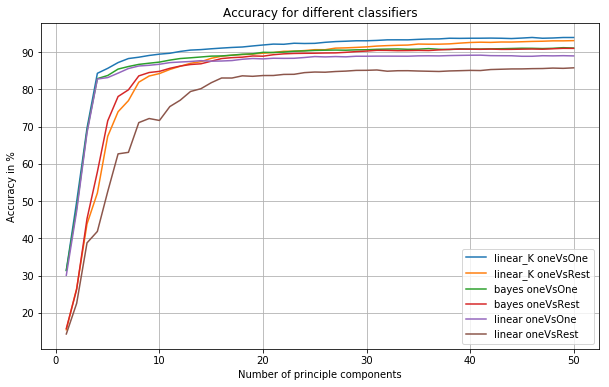

In [62]:
fig = plt.figure()

nPC = range(1, maxNumPC+1)
for i in [4, 1, 5, 2, 3, 0]:
    expt, m, p = exptList[i]
    plt.plot(nPC,accList[expt],label="{} {}".format(modelList[m],policyList2[p]))
plt.ylabel("Accuracy in %")
plt.xlabel("Number of principle components")
plt.title("Accuracy for different classifiers")
plt.grid("on")
plt.legend()
fig.set_size_inches(10,6)
fName = os.path.join(pDir,'accuracy_n{}_{}.png'.format(n,rev))
savefig(fName, bbox_inches='tight')
plt.show()

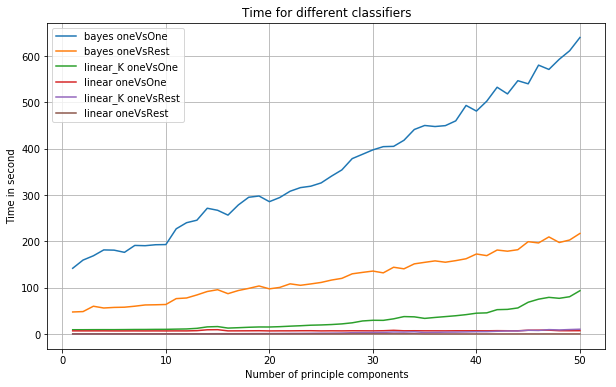

In [63]:
fig = plt.figure()
nPC = range(1, maxNumPC+1)
for i in [5, 2, 4, 3, 1, 0] :
    expt, m, p = exptList[i]
    plt.plot(nPC,timeList[expt],label="{} {}".format(modelList[m],policyList2[p]))
plt.ylabel("Time in second")
plt.xlabel("Number of principle components")
plt.title("Time for different classifiers")
plt.grid("on")
plt.legend()
fig.set_size_inches(10,6)
fName = os.path.join(pDir,'time_n{}_{}.png'.format(n,rev))
savefig(fName, bbox_inches='tight')
plt.show()

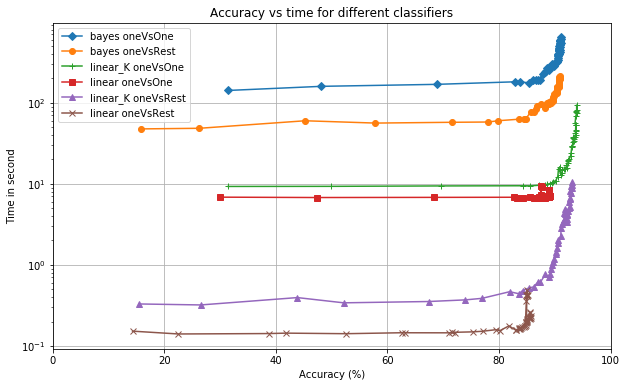

In [64]:
fig = plt.figure()
nPC = range(1, maxNumPC+1)
maker = ['x','s','^','+','o','D']
for i in [5, 2, 4, 3, 1, 0] :
    expt, m, p = exptList[i]
    plt.semilogy(accList[expt],timeList[expt],'-'+maker[2*m+p],label="{} {}".format(modelList[m],policyList2[p]))
plt.ylabel("Time in second")
plt.xlabel("Accuracy (%)")
plt.title("Accuracy vs time for different classifiers")
plt.xlim([0,100])
plt.grid("on")
plt.legend(loc="best")
fig.set_size_inches(10,6)
fName = os.path.join(pDir,'accuracy_time_n{}_{}.png'.format(n,rev))
savefig(fName, bbox_inches='tight')
plt.show()

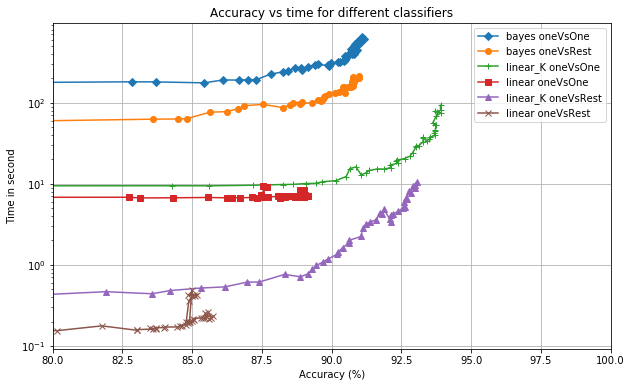

In [65]:
fig = plt.figure()
nPC = range(1, maxNumPC+1)
maker = ['x','s','^','+','o','D']
for i in [5, 2, 4, 3, 1, 0] :
    expt, m, p = exptList[i]
    plt.semilogy(accList[expt],timeList[expt],'-'+maker[2*m+p],label="{} {}".format(modelList[m],policyList2[p]))
plt.ylabel("Time in second")
plt.xlabel("Accuracy (%)")
plt.title("Accuracy vs time for different classifiers")
plt.xlim([80,100])
plt.grid("on")
plt.legend(loc="best")
fig.set_size_inches(10,6)
fName = os.path.join(pDir,'accuracy_time_zoom_n{}_{}.png'.format(n,rev))
savefig(fName, bbox_inches='tight')
plt.show()

In [66]:
#numPC = 2
#cb, cb_test = train_and_test(X,T,X_test,T_test,digits,V,mu,numPC)
#cb, cb_test = train_and_test_allvsall(X,T,X_test,T_test,digits,numPC)
#
#

In [67]:
##CM = get_CM(T , cb, digits)
##CM.columns = letters
##CM.index = letters
##fName = os.path.join(rDir,"cm_train_n{}_{}.csv".format(numPC,rev))
##CM.to_csv(fName)
##CM
##
##

In [68]:
#CM_test = get_CM(T_test , cb_test, digits)
##CM_test.columns = letters
##CM_test.index = letters
##fName = os.path.join(rDir,"cm_test_n{}_{}.csv".format(numPC,rev))
##CM.to_csv(fName)
##CM
#
#

In [69]:
##accuracy_train  = get_acc(T , cb) * 100
##print "accuracy for training =", accuracy_train
#
#

In [70]:
#accuracy_test  = get_acc(T_test , cb_test) * 100
#print "accuracy for testing  =", accuracy_test
#
#acc_arr = np.zeros(shape = (digits.shape[0]))
#sens_arr = np.zeros(shape = (digits.shape[0]))
#spec_arr = np.zeros(shape = (digits.shape[0]))
#ppv_arr = np.zeros(shape = (digits.shape[0]))
#
#for dig_i in range(digits.shape[0]):
#    TP = np.sum(CM_test[dig_i][dig_i])
#    FN = np.sum(CM_test[dig_i][:]) -TP
#    FP = np.sum(CM_test[:][dig_i]) -TP
#    TN = np.sum(np.sum(CM_test)) - TP - FN - FP      
#    acc_arr[dig_i] = get_accuracy(TP,FN,FP,TN)
#    sens_arr[dig_i] = get_sensitivity(TP,FN,FP,TN)
#    spec_arr[dig_i] = get_specificity(TP,FN,FP,TN)
#    ppv_arr[dig_i] = get_ppv(TP,FN,FP,TN)
#    #print "CM2_",dig_i,":", CM2_arr[dig_i]
#
#print "acc_arr",acc_arr
#print "sens_arr",sens_arr
#print "spec_arr",spec_arr
#print "ppv_arr",ppv_arr
#print 

Calculating Confusion Matrix and Metrics

In [71]:
from IPython.display import display

metrics_list = sorted(metrics_func.keys())

numPC = 16

for expt, model, kesler_switch in exptList: 
    # Short ver:
    #if model == 2 or (kesler_switch==1 and model > 0) : continue
    print "Confusion Matrix and Metrics for {} {} with {} PC".format(modelList[model],policyList2[kesler_switch],numPC)
    if (kesler_switch == 0):
        cb, cb_test = train_and_test_onevsall(X,T,X_test,T_test,digits,numPC,model)
    else:
        cb, cb_test = train_and_test_allvsall(X,T,X_test,T_test,digits,numPC,model)
    CM_test = get_CM(cb_test , T_test, digits)
    CM_test.columns = letters
    CM_test.index = letters
    fName = os.path.join(rDir,"cm_test_{}_n{}_{}.csv".format(expt,numPC,rev))
    CM_test.to_csv(fName)
    display(CM_test)
    metrics_df = pd.DataFrame(data=0.0,index=metrics_list,columns=letters)
    for digit in digits :
        cm_dig_t = get_CM2(T_test, cb_test, digit).flatten()
        for metric in metrics_list :
            metrics_df[digit2letter[digit]][metric] = round(metrics_func[metric](*cm_dig_t),2)
    metrics_df['Min'] = np.min(metrics_df,axis=1)
    fName = os.path.join(rDir,"metrics_test_{}_n{}_{}.csv".format(expt,numPC,rev))
    metrics_df.to_csv(fName)
    display(metrics_df)


Confusion Matrix and Metrics for linear oneVsRest with 16 PC


,A,B,C,D,E,F,G,H,I,J
A,809.0,24.0,5.0,10.0,23.0,10.0,16.0,24.0,15.0,5.0
B,5.0,782.0,5.0,13.0,41.0,3.0,8.0,9.0,5.0,3.0
C,4.0,10.0,903.0,8.0,65.0,5.0,94.0,5.0,7.0,14.0
D,11.0,43.0,18.0,897.0,12.0,19.0,16.0,16.0,14.0,17.0
E,3.0,12.0,9.0,1.0,685.0,3.0,13.0,28.0,4.0,1.0
F,24.0,20.0,10.0,11.0,48.0,903.0,21.0,15.0,12.0,15.0
G,13.0,8.0,16.0,5.0,22.0,5.0,774.0,6.0,7.0,4.0
H,83.0,36.0,7.0,9.0,24.0,9.0,13.0,845.0,12.0,7.0
I,12.0,34.0,18.0,14.0,61.0,23.0,16.0,22.0,853.0,82.0
J,36.0,31.0,9.0,32.0,19.0,20.0,29.0,30.0,71.0,852.0


,A,B,C,D,E,F,G,H,I,J,Min
Accuracy,0.97,0.97,0.97,0.97,0.96,0.97,0.97,0.96,0.96,0.96,0.96
PPV,0.86,0.89,0.81,0.84,0.90,0.84,0.90,0.81,0.75,0.75,0.75
Sensitivity,0.81,0.78,0.90,0.90,0.69,0.90,0.77,0.84,0.85,0.85,0.69
Specificity,0.99,0.99,0.98,0.98,0.99,0.98,0.99,0.98,0.97,0.97,0.97


Confusion Matrix and Metrics for linear_K oneVsRest with 16 PC


,A,B,C,D,E,F,G,H,I,J
A,875.0,9.0,3.0,5.0,5.0,1.0,2.0,21.0,9.0,4.0
B,10.0,849.0,5.0,27.0,22.0,4.0,12.0,11.0,6.0,2.0
C,4.0,6.0,910.0,10.0,29.0,5.0,38.0,4.0,5.0,4.0
D,6.0,27.0,4.0,883.0,0.0,7.0,9.0,9.0,8.0,5.0
E,6.0,25.0,18.0,6.0,871.0,6.0,15.0,8.0,8.0,3.0
F,7.0,15.0,13.0,10.0,27.0,938.0,22.0,20.0,16.0,13.0
G,11.0,17.0,18.0,13.0,13.0,6.0,862.0,11.0,9.0,5.0
H,35.0,17.0,4.0,10.0,2.0,3.0,10.0,888.0,9.0,2.0
I,9.0,14.0,19.0,14.0,24.0,15.0,13.0,12.0,881.0,31.0
J,37.0,21.0,6.0,22.0,7.0,15.0,17.0,16.0,49.0,931.0


,A,B,C,D,E,F,G,H,I,J,Min
Accuracy,0.98,0.97,0.98,0.98,0.98,0.98,0.98,0.98,0.97,0.97,0.97
PPV,0.94,0.90,0.90,0.92,0.90,0.87,0.89,0.91,0.85,0.83,0.83
Sensitivity,0.88,0.85,0.91,0.88,0.87,0.94,0.86,0.89,0.88,0.93,0.85
Specificity,0.99,0.99,0.99,0.99,0.99,0.98,0.99,0.99,0.98,0.98,0.98


Confusion Matrix and Metrics for bayes oneVsRest with 16 PC


,A,B,C,D,E,F,G,H,I,J
A,878.0,12.0,3.0,8.0,3.0,3.0,5.0,21.0,10.0,5.0
B,10.0,843.0,6.0,23.0,9.0,5.0,14.0,28.0,7.0,1.0
C,3.0,3.0,893.0,11.0,30.0,2.0,49.0,1.0,0.0,3.0
D,8.0,31.0,5.0,879.0,1.0,4.0,10.0,10.0,11.0,6.0
E,4.0,24.0,31.0,5.0,869.0,8.0,11.0,4.0,7.0,5.0
F,3.0,12.0,16.0,16.0,39.0,930.0,10.0,12.0,12.0,9.0
G,12.0,14.0,25.0,16.0,17.0,8.0,862.0,9.0,11.0,4.0
H,29.0,17.0,6.0,5.0,9.0,4.0,17.0,866.0,10.0,3.0
I,10.0,20.0,6.0,12.0,16.0,7.0,9.0,28.0,871.0,30.0
J,43.0,24.0,9.0,25.0,7.0,29.0,13.0,21.0,61.0,934.0


,A,B,C,D,E,F,G,H,I,J,Min
Accuracy,0.98,0.97,0.98,0.98,0.98,0.98,0.97,0.98,0.97,0.97,0.97
PPV,0.93,0.89,0.90,0.91,0.90,0.88,0.88,0.90,0.86,0.80,0.80
Sensitivity,0.88,0.84,0.89,0.88,0.87,0.93,0.86,0.87,0.87,0.93,0.84
Specificity,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.97,0.97


Confusion Matrix and Metrics for linear oneVsOne with 16 PC


,A,B,C,D,E,F,G,H,I,J
A,882.0,9.0,3.0,8.0,7.0,5.0,10.0,27.0,11.0,6.0
B,9.0,840.0,5.0,21.0,10.0,0.0,8.0,5.0,7.0,2.0
C,3.0,5.0,910.0,8.0,34.0,5.0,52.0,1.0,4.0,2.0
D,6.0,28.0,3.0,874.0,2.0,8.0,8.0,11.0,11.0,7.0
E,9.0,17.0,11.0,8.0,848.0,3.0,10.0,10.0,13.0,4.0
F,3.0,16.0,16.0,15.0,27.0,925.0,18.0,27.0,19.0,8.0
G,9.0,8.0,15.0,9.0,13.0,4.0,839.0,3.0,3.0,2.0
H,31.0,23.0,3.0,8.0,8.0,2.0,7.0,875.0,11.0,2.0
I,16.0,27.0,15.0,21.0,34.0,20.0,19.0,20.0,867.0,68.0
J,32.0,27.0,19.0,28.0,17.0,28.0,29.0,21.0,54.0,899.0


,A,B,C,D,E,F,G,H,I,J,Min
Accuracy,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.96,0.96,0.96
PPV,0.91,0.93,0.89,0.91,0.91,0.86,0.93,0.90,0.78,0.78,0.78
Sensitivity,0.88,0.84,0.91,0.87,0.85,0.93,0.84,0.88,0.87,0.90,0.84
Specificity,0.99,0.99,0.99,0.99,0.99,0.98,0.99,0.99,0.97,0.97,0.97


Confusion Matrix and Metrics for linear_K oneVsOne with 16 PC


,A,B,C,D,E,F,G,H,I,J
A,926.0,8.0,3.0,8.0,6.0,5.0,9.0,17.0,12.0,6.0
B,13.0,905.0,8.0,29.0,17.0,3.0,13.0,22.0,9.0,3.0
C,3.0,2.0,913.0,3.0,24.0,2.0,18.0,2.0,3.0,1.0
D,2.0,13.0,2.0,902.0,2.0,3.0,6.0,4.0,9.0,5.0
E,1.0,15.0,21.0,5.0,896.0,6.0,14.0,5.0,11.0,5.0
F,1.0,7.0,11.0,5.0,16.0,940.0,20.0,16.0,15.0,8.0
G,13.0,12.0,26.0,13.0,16.0,10.0,894.0,10.0,9.0,1.0
H,17.0,13.0,4.0,10.0,3.0,3.0,5.0,903.0,4.0,2.0
I,8.0,12.0,7.0,8.0,13.0,11.0,7.0,8.0,880.0,22.0
J,16.0,13.0,5.0,17.0,7.0,17.0,14.0,13.0,48.0,947.0


,A,B,C,D,E,F,G,H,I,J,Min
Accuracy,0.99,0.98,0.99,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98
PPV,0.93,0.89,0.94,0.95,0.92,0.90,0.89,0.94,0.90,0.86,0.86
Sensitivity,0.93,0.91,0.91,0.90,0.90,0.94,0.89,0.90,0.88,0.95,0.88
Specificity,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.98


Confusion Matrix and Metrics for bayes oneVsOne with 16 PC


,A,B,C,D,E,F,G,H,I,J
A,886.0,17.0,3.0,11.0,4.0,3.0,9.0,24.0,17.0,8.0
B,9.0,876.0,6.0,26.0,9.0,4.0,10.0,32.0,5.0,3.0
C,4.0,3.0,915.0,10.0,35.0,1.0,45.0,0.0,2.0,3.0
D,7.0,25.0,4.0,886.0,4.0,4.0,6.0,8.0,11.0,10.0
E,3.0,20.0,29.0,7.0,885.0,4.0,13.0,2.0,13.0,3.0
F,3.0,5.0,9.0,8.0,18.0,931.0,11.0,14.0,14.0,7.0
G,12.0,14.0,24.0,10.0,18.0,9.0,872.0,7.0,12.0,4.0
H,37.0,9.0,0.0,9.0,3.0,0.0,7.0,866.0,5.0,1.0
I,10.0,14.0,8.0,11.0,17.0,22.0,15.0,33.0,864.0,47.0
J,29.0,17.0,2.0,22.0,7.0,22.0,12.0,14.0,57.0,914.0


,A,B,C,D,E,F,G,H,I,J,Min
Accuracy,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.97,0.97,0.97
PPV,0.90,0.89,0.90,0.92,0.90,0.91,0.89,0.92,0.83,0.83,0.83
Sensitivity,0.89,0.88,0.92,0.89,0.89,0.93,0.87,0.87,0.86,0.91,0.86
Specificity,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.98,0.98
